# Networks of organisations


  
* *Exploratory SNA* book's chapter 5 about 'Affiliations'
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/pajek_book/chapter5_affiliations.ipynb) 



In [17]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os
import pandas as pd

In [18]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [19]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [20]:
print(reload(naf))  

<module 'network_analysis_functions' from 'c:\\Users\\berna\\Desktop\\UNINE\\Semestre 4\\Applications méthodes\\Projet\\Formula1_drivers\\Notebooks_jupyther\\wikidata_exploration\\..\\network_analysis_functions.py'>


## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisations as original information.

Here, however, we will focus on relationships between institutions, so the treatment is different.


In [21]:
## define SPARQL enpoint
endpoint = "https://ag1cupvpzk0xd2wm.allegrograph.cloud/repositories/F1drivers"

In [22]:
query = """

PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?person
       (MIN(?pLabel)        AS ?personLabel)
       (MIN(?birth)         AS ?birthYear)
       ?relationship
       ?team
       (MIN(?teamLabel)     AS ?organisationLabel)
       (COUNT(*)            AS ?n)
       (GROUP_CONCAT(DISTINCT ?teamTypeLabel; separator=" | ")
                        AS ?groupTypes)
WHERE {
  GRAPH <https://github.com/Benmad26/Formula1_drivers/blob/main/graphs/wikidata-imported-data.md> {

    #--- pilote -------------------------------------------------------------
    ?person rdf:type wd:Q5 ;
            rdfs:label ?pLabel ;
            wdt:P569   ?birth ;
            wdt:P54    ?team .
    FILTER (
        langMatches(lang(?pLabel), "en") ||     # toutes variantes en-*
        langMatches(lang(?pLabel), "fr") ||     # toutes variantes fr-*
        lang(?pLabel) = ""                      # ou pas de balise
    )

    BIND("membership" AS ?relationship)

    #--- écurie -------------------------------------------------------------
    OPTIONAL {
      ?team rdfs:label ?teamLabel .
      FILTER (
          langMatches(lang(?teamLabel), "en") ||
          langMatches(lang(?teamLabel), "fr") ||
          lang(?teamLabel) = ""
      )
    }

    #--- type d’écurie ------------------------------------------------------
    OPTIONAL {
      ?team wdt:P31 ?teamType .
      ?teamType rdfs:label ?teamTypeLabel .
      FILTER (
          langMatches(lang(?teamTypeLabel), "en") ||
          langMatches(lang(?teamTypeLabel), "fr") ||
          lang(?teamTypeLabel) = ""
      )
    }
  }
}
GROUP BY ?person ?team ?relationship
ORDER BY ?personLabel

"""

In [23]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


442
[['http://www.wikidata.org/entity/Q435698',
  'Enrico Bertaggia',
  '1964',
  'membership',
  'http://www.wikidata.org/entity/Q172974',
  'Forti',
  '1',
  'Formula One team'],
 ['http://www.wikidata.org/entity/Q435698',
  'Enrico Bertaggia',
  '1964',
  'membership',
  'http://www.wikidata.org/entity/Q172857',
  'Lola Cars',
  '2',
  'auto racing team | Formula One team'],
 ['http://www.wikidata.org/entity/Q435698',
  'Enrico Bertaggia',
  '1964',
  'membership',
  'http://www.wikidata.org/entity/Q173293',
  'Andrea Moda Formula',
  '1',
  'Formula One team']]


## Inspect the data


In [24]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  442


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg
10,http://www.wikidata.org/entity/Q516070,Alberto Colombo,1946,membership,http://www.wikidata.org/entity/Q172577,Merzario,1,Formula One team
11,http://www.wikidata.org/entity/Q516070,Alberto Colombo,1946,membership,http://www.wikidata.org/entity/Q172162,ATS F1,1,Formula One team
12,http://www.wikidata.org/entity/Q16149172,Alexander Albon,1996,membership,http://www.wikidata.org/entity/Q171337,Williams Racing,2,racecar constructor | Formula One team


### Distribution of relationships in relation to birthYears of organisations members

In [25]:
l_50 = list(range(1761, 2051, 30))
print(l_50)

[1761, 1791, 1821, 1851, 1881, 1911, 1941, 1971, 2001, 2031]


In [26]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [27]:
### 30 years periods, but some customisations
lc = [1751, 1811, 1851, 1881, 1911, 1941, 1971, 2001]

In [28]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [29]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
1,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,membership,http://www.wikidata.org/entity/Q5559629,Bravo F1,1,auto racing team,1941-1970
5,http://www.wikidata.org/entity/Q10494,Alain Prost,1955,membership,http://www.wikidata.org/entity/Q172722,Renault F1 Team,1,Formula One team,1941-1970
10,http://www.wikidata.org/entity/Q516070,Alberto Colombo,1946,membership,http://www.wikidata.org/entity/Q172577,Merzario,1,Formula One team,1941-1970


#### Reload from CSV

This is only possible if you already stored the data into a CSV, cf. below

In [30]:
### load from CSV

os.makedirs('Data', exist_ok=True)
df_p.to_csv('Data/persons_organisations_from_organisations.csv', index=False)
print(len(df_p))
df_p.head(2)


442


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
0,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,membership,http://www.wikidata.org/entity/Q1031592,Campos Racing,1,auto racing team,1941-1970
1,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,membership,http://www.wikidata.org/entity/Q5559629,Bravo F1,1,auto racing team,1941-1970


In [31]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1881-1910     12
1911-1940    148
1941-1970    143
1971-2000    139
dtype: int64


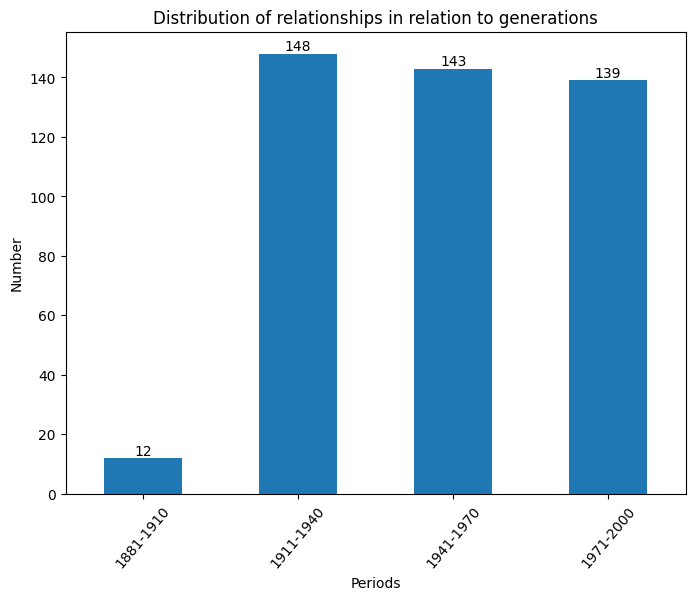

In [32]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Inspect available relationships

In [33]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
membership    442
dtype: int64


In [34]:
dfg_pr=df_p.groupby(by=['periods','relaType'], observed=True, as_index=False).size()
print(dfg_pr)

     periods    relaType  size
0  1881-1910  membership    12
1  1911-1940  membership   148
2  1941-1970  membership   143
3  1971-2000  membership   139


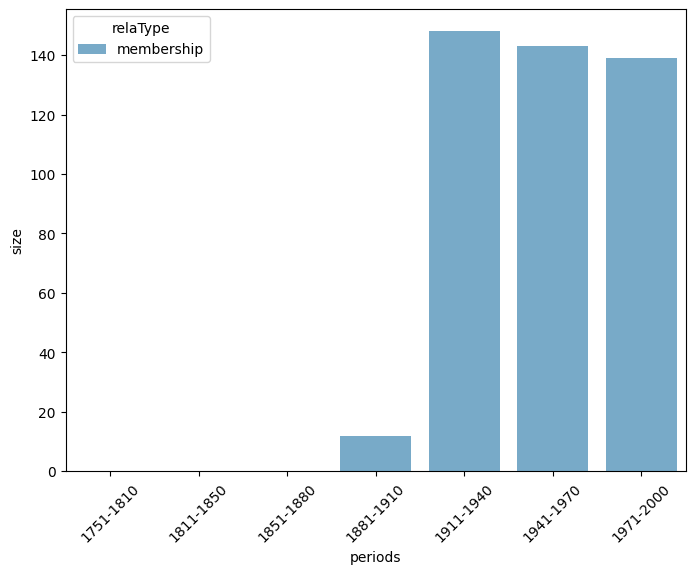

In [35]:
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='relaType', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up organisations type

In [36]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


442
[['auto racing team'], ['auto racing team'], ['formula one team']]


In [37]:
## Rebuild the sorted original texts after sorting
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
1,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,membership,http://www.wikidata.org/entity/Q5559629,Bravo F1,1,auto racing team,1941-1970,[auto racing team]
5,http://www.wikidata.org/entity/Q10494,Alain Prost,1955,membership,http://www.wikidata.org/entity/Q172722,Renault F1 Team,1,formula one team,1941-1970,[formula one team]
10,http://www.wikidata.org/entity/Q516070,Alberto Colombo,1946,membership,http://www.wikidata.org/entity/Q172577,Merzario,1,formula one team,1941-1970,[formula one team]


#### Organisations' types distribution

In [38]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

typesOrg
formula one team                              221
auto racing team                               72
formula one team | organization                53
automobile manufacturer | formula one team     22
formula one team | racecar constructor         22
auto racing team | stable                      17
business | formula one team | organization      6
formula one team | stable                       5
auto racing team | automobile manufacturer      4
formula one team | sports organization          3
dtype: int64


#### Save dataframe to CSV

In [39]:
file_add = 'data/persons_organisations_from_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

## Types of organisations

Property **wdt:P31 instance of**


We are trying to figure out if we can use these types to distinguish and categorise organisations. We will introduce high-level, research-driven classes that primarily serve a heuristic function and express no objective point of view.

In [40]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,formula one team,221,1
1,auto racing team,72,1
2,formula one team | organization,53,2
3,automobile manufacturer | formula one team,22,2
4,formula one team | racecar constructor,22,2
5,auto racing team | stable,17,2
6,business | formula one team | organization,6,3
7,formula one team | stable,5,2
8,auto racing team | automobile manufacturer,4,2
9,formula one team | sports organization,3,2


In [41]:
### Print to CSV in order to inspect the data
csv_file='Data/network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Add organisation main type

In [42]:
### Inspect the data
df_p.head(1)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,membership,http://www.wikidata.org/entity/Q1031592,Campos Racing,1,auto racing team,1941-1970,[auto racing team]


In [43]:
def code_organisation_main_type(x: str) -> str:
    x = x.lower() if x else ''
    val = ''

    # ——— 1. nouvelles catégories « racing team / manufacturer » ———
    if ('formula one team' in x or
        'auto racing team' in x or
        'racecar constructor' in x or
        'racing team' in x or
        'stable' in x):
        val = 'racing team'
    elif 'automobile manufacturer' in x or 'motor vehicle manufacturer' in x:
        val = 'manufacturer'

    # ——— 2. toutes tes règles d’origine inchangées ———
    elif 'institute of technol' in x or 'polyt' in x:
        val = 'institute of technology'
    elif 'observato' in x:
        val = 'astronomical observatory'
    elif ('public university' in x or 'école normale sup' in x or
          'grande école' in x or 'grand établissement' in x):
        val = 'public university'
    elif 'private university' in x:
        val = 'private university'
    elif 'university' in x:
        val = 'university'
    elif ('educational inst' in x or 'military academy' in x or
          'naval academy' in x or 'art academy' in x or
          'college' in x or 'gymnas' in x or 'higher education' in x or
          'school' in x or 'academic institution' in x):
        val = 'educational institution'
    elif 'faculty' in x or 'academic dep' in x:
        val = 'university'         # autre option : 'faculty'
    elif 'learned society' in x or 'society' in x:
        val = 'learned society'
    elif 'academy of sciences' in x:
        val = 'academy of sciences'
    elif ('research institute' in x or 'max planck' in x or
          'institute' in x or 'research' in x):
        val = 'research organisation'
    elif 'laboratory' in x or 'facility' in x:
        val = 'research facility'
    elif ('scientific society' in x or 'scientific organisation' in x or
          'scientific organization' in x or 'museum' in x or
          'nonprofit organization' in x or 'national academy' in x):
        val = 'scientific organisation'
    elif 'academy' in x:
        val = 'learned society'
    elif ('company' in x or 'business' in x or 'entrepr' in x or
          'government' in x or 'publish' in x or 'journal' in x or
          'periodical' in x):
        val = 'company or gov. agency'
    else:
        val = 'not classified organisation'

    return val
    

In [44]:
df_p['orgMainType'] = df_p['typesOrg'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
7,http://www.wikidata.org/entity/Q172753,Alan Jones,1946,membership,http://www.wikidata.org/entity/Q173879,Shadow Racing Cars,1,formula one team,1941-1970,[formula one team],racing team
8,http://www.wikidata.org/entity/Q172753,Alan Jones,1946,membership,http://www.wikidata.org/entity/Q171337,Williams Racing,2,formula one team | racecar constructor,1941-1970,"[formula one team, racecar constructor]",racing team
9,http://www.wikidata.org/entity/Q172753,Alan Jones,1946,membership,http://www.wikidata.org/entity/Q173306,Surtees,1,formula one team,1941-1970,[formula one team],racing team


In [45]:
df_mainTypes = pd.DataFrame(df_p.groupby(by='orgMainType', as_index=False).size().sort_values(by='size',ascending=False))
df_mainTypes.columns=['mainType', 'number']
df_mainTypes

,mainType,number
2,racing team,433
1,not classified organisation,7
0,company or gov. agency,2


In [46]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby(['typesOrg', 'orgMainType'], as_index=False).\
                        size().sort_values(by='size',ascending=False))
df_types.columns=['typesOrg', 'orgMainType', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
### Print to CSV in order to inspect the data
csv_file='Data/network_organisations_with_main_types_groups.csv'
df_types.to_csv(csv_file)

df_types.iloc[7:10]

,typesOrg,orgMainType,number,numberOrg
18,formula one team | stable,racing team,5,2
2,auto racing team | automobile manufacturer,racing team,4,2
17,formula one team | sports organization,racing team,3,2


#### 'Manual' corrections and classification improvements

In some cases, instpecting the organisations shows that the provided classification is not suitable and should be replaced:

Academia Europaea, ...

We provide this example merely to illustrate the point; further work would be required, but this is beyond the scope of this exercise.

In [47]:
### Please note the warning and the orders fo the filter, after (!) the column 
"""
Do not use:
df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
"""

df_p.loc[df_p.uriOrg == 'http://www.wikidata.org/entity/Q337234', 'orgMainType'] = 'research organisation'
df_p[df_p.labelOrg.str.contains('Europaea')].head(2)



,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType


# Create graphs

In [48]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
membership    442
dtype: int64


### Prepare the dataframe

In [49]:
### Select the columns that will be used
df_prep = df_p[['uriPer','labelPer','birthYear','uriOrg', 'labelOrg', 'typesOrg', 'orgMainType', 'relaType', 'periods']].copy(deep=True)
print(len(df_prep))

442


### Features of organisations

#### General grouping


We first group by organisations, counting all relationships of persons which provides the total degree or number of members over the whole time 

In [50]:
### Memberships by organisations
df_org = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'typesOrg','orgMainType'],as_index=False).size())
df_org.columns=['uriOrg', 'labelOrg', 'typesOrg', 'orgMainType','tot_members_number']
df_org.sort_values('tot_members_number',ascending=False).iloc[:10]

,uriOrg,labelOrg,typesOrg,orgMainType,tot_members_number
21,http://www.wikidata.org/entity/Q169898,Scuderia Ferrari,formula one team,racing team,23
132,http://www.wikidata.org/entity/Q622489,Alfa Romeo Racing,formula one team | organization,racing team,23
25,http://www.wikidata.org/entity/Q171337,Williams Racing,formula one team | racecar constructor,racing team,22
34,http://www.wikidata.org/entity/Q172030,McLaren,formula one team | organization,racing team,19
77,http://www.wikidata.org/entity/Q173996,Team Lotus,auto racing team | stable,racing team,17
51,http://www.wikidata.org/entity/Q173012,British Racing Motors,formula one team,racing team,15
50,http://www.wikidata.org/entity/Q173003,Cooper Car Company,automobile manufacturer | formula one team,racing team,13
42,http://www.wikidata.org/entity/Q172722,Renault F1 Team,formula one team,racing team,11
55,http://www.wikidata.org/entity/Q173103,Brabham,formula one team,racing team,10
71,http://www.wikidata.org/entity/Q173762,Scuderia Centro Sud,formula one team,racing team,10


In [51]:
### Save list of organisations as CSV
csv_file='Data/network_organisations_with_main_type_and_number.csv'
df_org.sort_values('tot_members_number',ascending=False).to_csv(csv_file)

#### Group by period

We then group by heuristic period (or generation)

In [52]:
df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriod.reset_index(inplace=True)
df_orgPeriod.sort_values(by='periods', ascending=True).head()

C:\Users\berna\AppData\Local\Temp\ipykernel_15636\422249010.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'periods']).size(), columns=['period_members_number'])


,uriOrg,labelOrg,orgMainType,periods,period_members_number
0,http://www.wikidata.org/entity/Q1029684,A1 Team Germany,company or gov. agency,1751-1810,0
468391,http://www.wikidata.org/entity/Q8052439,Scuderia Centro Sud,not classified organisation,1751-1810,0
184856,http://www.wikidata.org/entity/Q173177,Manor Motorsport,racing team,1751-1810,0
184849,http://www.wikidata.org/entity/Q173177,Manor Motorsport,not classified organisation,1751-1810,0
184842,http://www.wikidata.org/entity/Q173177,Manor Motorsport,company or gov. agency,1751-1810,0


In [53]:
df_orgPeriod[df_orgPeriod.labelOrg=='AMOLF']

,uriOrg,labelOrg,orgMainType,periods,period_members_number


#### Group by period and relationship type

We then group by heuristic period (or generation) AND relationship type, i.e. which kind of relationship associates a person to an organisation in the bipartite network

In [54]:
df_orgPeriodRelType = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriodRelType.reset_index(inplace=True)
df_orgPeriodRelType.sort_values(by='period_members_number', ascending=False).head()

C:\Users\berna\AppData\Local\Temp\ipykernel_15636\2562625167.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_orgPeriodRelType = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']).size(), columns=['period_members_number'])


,uriOrg,labelOrg,orgMainType,relaType,periods,period_members_number
164385,http://www.wikidata.org/entity/Q173012,British Racing Motors,racing team,membership,1911-1940,12
161424,http://www.wikidata.org/entity/Q173003,Cooper Car Company,racing team,membership,1911-1940,12
83453,http://www.wikidata.org/entity/Q171337,Williams Racing,racing team,membership,1971-2000,11
250296,http://www.wikidata.org/entity/Q173996,Team Lotus,racing team,membership,1911-1940,11
83452,http://www.wikidata.org/entity/Q171337,Williams Racing,racing team,membership,1941-1970,11


In [55]:
### Number of relationships by period with type
dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values(['relaType', 'periods'])
file_addr='Data/organisations_types_periods_distribution.csv'
dfgt.sort_values(['relaType', 'periods']).to_csv(file_addr)
print(len(dfgt))
dfgt.iloc[:10]

21


C:\Users\berna\AppData\Local\Temp\ipykernel_15636\4136667425.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\


,periods,relaType,orgMainType,period_members_number
0,1751-1810,membership,company or gov. agency,0
1,1751-1810,membership,not classified organisation,0
2,1751-1810,membership,racing team,0
3,1811-1850,membership,company or gov. agency,0
4,1811-1850,membership,not classified organisation,0
5,1811-1850,membership,racing team,0
6,1851-1880,membership,company or gov. agency,0
7,1851-1880,membership,not classified organisation,0
8,1851-1880,membership,racing team,0
9,1881-1910,membership,company or gov. agency,1


In [56]:
### Number of relationships without period
dfgw = df_orgPeriodRelType.groupby(['relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values([ 'relaType', 'orgMainType'])
print(len(dfgw))

3


## Bivariate analysis: relationship, organisation type

### Create the needed functions

In [57]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [58]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships, types of organisations

In [59]:


### Contingency table
X = 'relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



relaType,membership,Total
orgMainType,,
company or gov. agency,2,2
not classified organisation,7,7
racing team,433,433
Total,442,442


In [60]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

relaType,membership
orgMainType,
company or gov. agency,2
not classified organisation,7
racing team,433


In [61]:
### We observe a strong relationship between these two variables

from scipy import stats

def bivariee_stats(ct):
    """
    Affiche χ², p-value, phi² et Cramér V pour une table de contingence ct.
    """
    # effectif total
    n = ct.to_numpy().sum() if hasattr(ct, "to_numpy") else ct.sum()

    # test du χ²
    chi2, p_val, dof, expected = stats.chi2_contingency(ct)

    print("Chi2 :", round(chi2, 2), ", dof :", dof)
    print("p-value :", p_val)
    print()

    # inertie (phi²) et Cramér V
    phi2 = chi2 / n
    r, k = ct.shape
    cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5

    print("phi² (inertie) :", round(phi2, 4))
    print("Cramér V       :", round(cramers_v, 4))
# --------------------------------------------------------------------------

bivariee_stats(ct_wm)

Chi2 : 0.0 , dof : 0
p-value : 1.0

phi² (inertie) : 0.0
Cramér V       : nan


C:\Users\berna\AppData\Local\Temp\ipykernel_15636\3157640799.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5


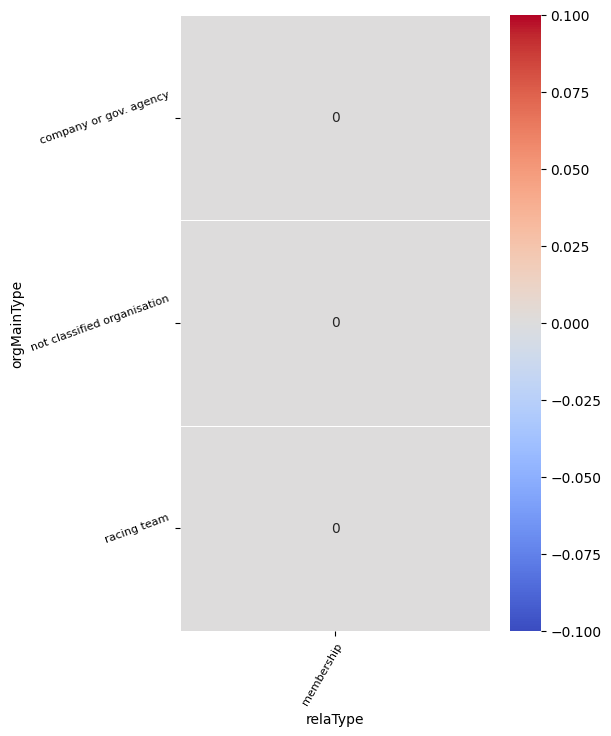

In [62]:
pp = plot_chi2_residuals(ct_wm, figsize=(5, 8))

#### Comment

We observe a strong relationship between these two variables which is explained by the fact that not all organisations types are concerned by the same relationship types

We also observe that some values should be corrected, like memberships in technical organisations that should be employments.

See the following example

In [63]:
pprint.pprint(list(df_p.loc[df_p.orgMainType.str.contains('techno') & df_p.relaType.str.contains('memb') ].items())[:6])

[('uriPer', Series([], Name: uriPer, dtype: object)),
 ('labelPer', Series([], Name: labelPer, dtype: object)),
 ('birthYear', Series([], Name: birthYear, dtype: int64)),
 ('relaType', Series([], Name: relaType, dtype: object)),
 ('uriOrg', Series([], Name: uriOrg, dtype: object)),
 ('labelOrg', Series([], Name: labelOrg, dtype: object))]


### Explore contingency table of relationships to organisations : periods, types of organisations

In [64]:
### Contingency table
X = 'periods'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1881-1910,1911-1940,1941-1970,1971-2000,Total
orgMainType,,,,,
company or gov. agency,1,0,0,1,2
not classified organisation,2,0,1,4,7
racing team,9,148,142,134,433
Total,12,148,143,139,442


In [65]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [66]:
### We observe some not so strong relationship between these two variables
bivariee_stats(ct_wm)

Chi2 : 40.53 , dof : 6
p-value : 3.5779898209921853e-07

phi² (inertie) : 0.0917
Cramér V       : 0.2141


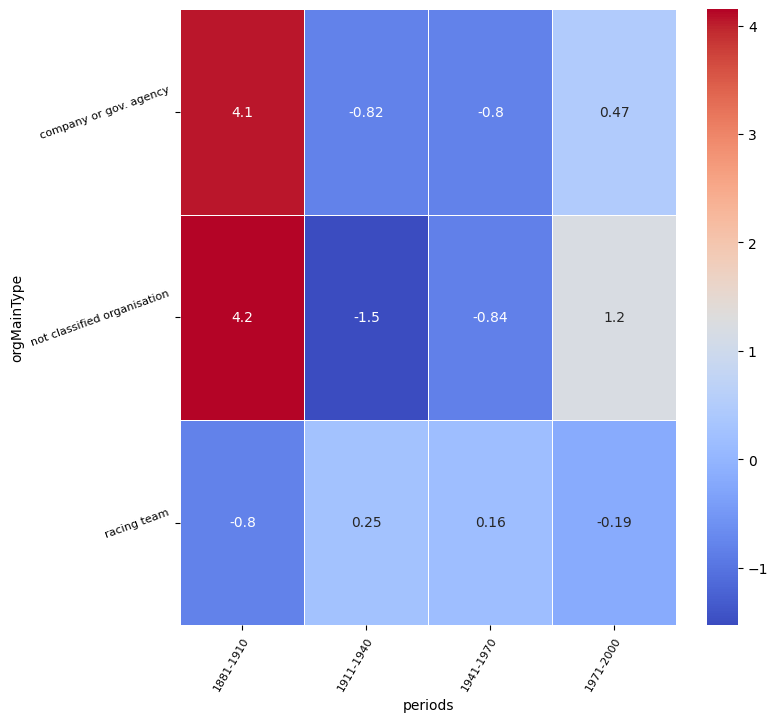

In [67]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 8))

### Explore contingency table of relationships to organisations : periods, types of relationships

In [68]:
### Contingency table
X = 'periods'
Y = 'relaType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1881-1910,1911-1940,1941-1970,1971-2000,Total
relaType,,,,,
membership,12,148,143,139,442
Total,12,148,143,139,442


In [69]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [70]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 0.0 , dof : 0
p-value : 1.0

phi² (inertie) : 0.0
Cramér V       : nan


C:\Users\berna\AppData\Local\Temp\ipykernel_15636\3157640799.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5


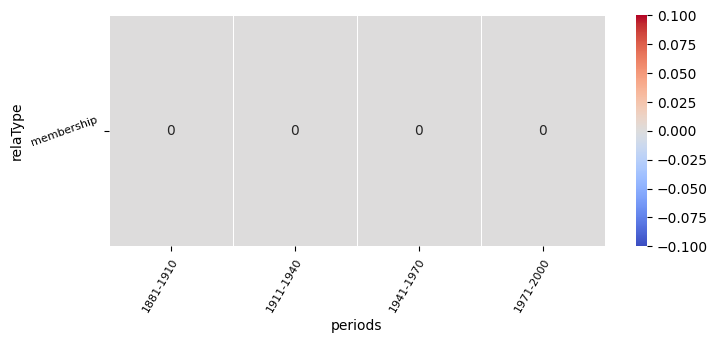

In [71]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 3))

### Explore contingency table of relationships to organisations : periods+types of relationships vs organisations types

In [72]:
df_prep['periods_relaType'] = df_prep.apply(lambda x : x.periods+'_'+x.relaType, axis=1)
df_prep.head(1)

,uriPer,labelPer,birthYear,uriOrg,labelOrg,typesOrg,orgMainType,relaType,periods,periods_relaType
0,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,http://www.wikidata.org/entity/Q1031592,Campos Racing,auto racing team,racing team,membership,1941-1970,1941-1970_membership


In [74]:
### Contingency table
X = 'periods_relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods_relaType,1881-1910_membership,1911-1940_membership,1941-1970_membership,1971-2000_membership,Total
orgMainType,,,,,
company or gov. agency,1,0,0,1,2
not classified organisation,2,0,1,4,7
racing team,9,148,142,134,433
Total,12,148,143,139,442


In [75]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [76]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 40.53 , dof : 6
p-value : 3.5779898209921853e-07

phi² (inertie) : 0.0917
Cramér V       : 0.2141


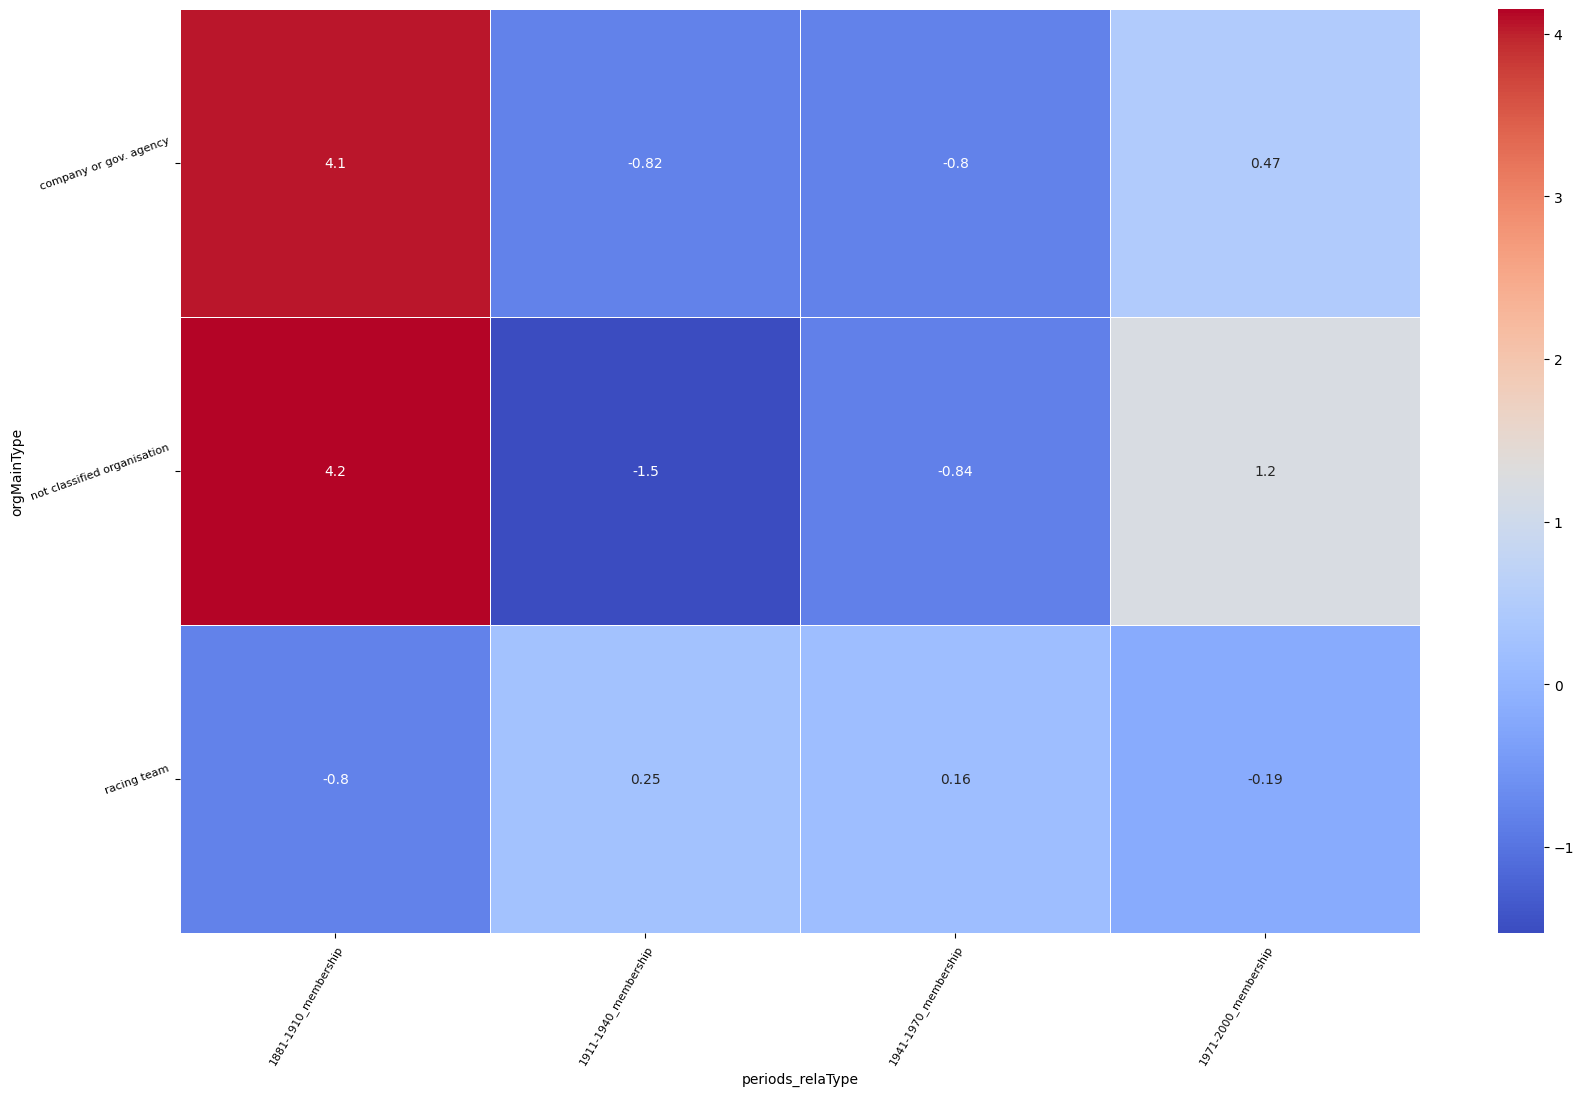

In [77]:
pp = plot_chi2_residuals(ct_wm, figsize=(20, 12))

## Prepare graph


In a heuristic perspective we take the persons as representing relationships among organisations.

Of course these relations are limited in time and with different meaning but in this general inspection of the field, we consider all the relationship. Filters are introduced later on.

We will create a projection of the graph on organisations and keep in a first stage all relationships, with types and periods, one per relationship, where the joining elements are those concerning uniquely the person

In [78]:
### Join on common organisation: Cartesian product -> produces a lot of rows !
merged = pd.merge(df_prep, df_prep, on=['uriPer','labelPer','birthYear', 'periods'])
print(len(merged))


1592


In [79]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriOrg_x'] < (merged['uriOrg_y'])]


In [80]:
### Inspect
print(len(merged))
print(list(merged.columns))
merged.iloc[110:114]

575
['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType_x', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'periods_relaType_y']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y
300,http://www.wikidata.org/entity/Q172832,David Coulthard,1971,http://www.wikidata.org/entity/Q172030,McLaren,formula one team | organization,racing team,membership,1971-2000,1971-2000_membership,http://www.wikidata.org/entity/Q173663,Red Bull Racing,formula one team,racing team,membership,1971-2000_membership
304,http://www.wikidata.org/entity/Q171879,David Murray,1909,http://www.wikidata.org/entity/Q2548586,Scuderia Ambrosiana,formula one team,racing team,membership,1881-1910,1881-1910_membership,http://www.wikidata.org/entity/Q3047147,Ecurie Ecosse,formula one team,racing team,membership,1881-1910_membership
307,http://www.wikidata.org/entity/Q171743,David Purley,1945,http://www.wikidata.org/entity/Q172841,Token Racing,formula one team,racing team,membership,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q2291349,LEC Refrigeration Racing,formula one team,racing team,membership,1941-1970_membership
312,http://www.wikidata.org/entity/Q3166,Denny Hulme,1936,http://www.wikidata.org/entity/Q172030,McLaren,formula one team | organization,racing team,membership,1911-1940,1911-1940_membership,http://www.wikidata.org/entity/Q927748,Tom Walkinshaw Racing,auto racing team,racing team,membership,1911-1940_membership


In [81]:
### Available ORIGINAL relationships
print(df_p.groupby(by='relaType').size())

relaType
membership    442
dtype: int64


In [82]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
0,membership,membership,575


### Swap values in order to have the same orientation for all relationships

All relationships should have the same 'orientation', which is determined by alphabetical order:

education -> employment -> membership

In [83]:
### Example
df = pd.DataFrame({
    'column1': ['A', 'B', 'C', 'D'],
    'column2': ['X', 'Y', 'Z', 'W']
})

condition = df['column1'] < df['column2']
df.loc[condition, ['column1', 'column2']] = df.loc[condition, ['column2', 'column1']].values

print(df)

  column1 column2
0       X       A
1       Y       B
2       Z       C
3       W       D


In [84]:
### Test whether the relationship types are in the wrong alphabetical order.
condition = merged.relaType_x > merged.relaType_y

In [85]:
### Transpose under condition that the relation orientation is 'wrong',
# i.e. not according the alphabatical order

merged.loc[condition, 
    ['uriOrg_x','labelOrg_x','orgMainType_x','relaType_x', 'uriOrg_y','labelOrg_y','orgMainType_y','relaType_y']] = \
        merged.loc[condition,
    ['uriOrg_y','labelOrg_y','orgMainType_y','relaType_y','uriOrg_x','labelOrg_x','orgMainType_x','relaType_x']].values

In [74]:
### Inspect

merged.iloc[110:117]

,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y
300,http://www.wikidata.org/entity/Q172832,David Coulthard,1971,http://www.wikidata.org/entity/Q172030,McLaren,formula one team | organization,racing team,membership,1971-2000,1971-2000_membership,http://www.wikidata.org/entity/Q173663,Red Bull Racing,formula one team,racing team,membership,1971-2000_membership
304,http://www.wikidata.org/entity/Q171879,David Murray,1909,http://www.wikidata.org/entity/Q2548586,Scuderia Ambrosiana,formula one team,racing team,membership,1881-1910,1881-1910_membership,http://www.wikidata.org/entity/Q3047147,Ecurie Ecosse,formula one team,racing team,membership,1881-1910_membership
307,http://www.wikidata.org/entity/Q171743,David Purley,1945,http://www.wikidata.org/entity/Q172841,Token Racing,formula one team,racing team,membership,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q2291349,LEC Refrigeration Racing,formula one team,racing team,membership,1941-1970_membership
312,http://www.wikidata.org/entity/Q3166,Denny Hulme,1936,http://www.wikidata.org/entity/Q172030,McLaren,formula one team | organization,racing team,membership,1911-1940,1911-1940_membership,http://www.wikidata.org/entity/Q927748,Tom Walkinshaw Racing,auto racing team,racing team,membership,1911-1940_membership
313,http://www.wikidata.org/entity/Q3166,Denny Hulme,1936,http://www.wikidata.org/entity/Q172030,McLaren,formula one team | organization,racing team,membership,1911-1940,1911-1940_membership,http://www.wikidata.org/entity/Q173103,Brabham,formula one team,racing team,membership,1911-1940_membership
315,http://www.wikidata.org/entity/Q3166,Denny Hulme,1936,http://www.wikidata.org/entity/Q172030,McLaren,formula one team | organization,racing team,membership,1911-1940,1911-1940_membership,http://www.wikidata.org/entity/Q8052439,Yeoman Credit Racing,auto racing team,racing team,membership,1911-1940_membership
316,http://www.wikidata.org/entity/Q3166,Denny Hulme,1936,http://www.wikidata.org/entity/Q172030,McLaren,formula one team | organization,racing team,membership,1911-1940,1911-1940_membership,http://www.wikidata.org/entity/Q173450,All American Racers,formula one team,racing team,membership,1911-1940_membership


In [86]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
0,membership,membership,575


In [87]:
import pandas as pd

# liste tous les DataFrames actuellement en mémoire
print("DataFrames actuellement définis :")
for name, obj in globals().items():
    if isinstance(obj, pd.DataFrame):
        print(f"  {name:20} → shape = {obj.shape}")

DataFrames actuellement définis :
  _                    → shape = (1, 3)
  __                   → shape = (1, 3)
  ___                  → shape = (4, 16)
  df_p                 → shape = (442, 11)
  _24                  → shape = (3, 8)
  _29                  → shape = (3, 9)
  _30                  → shape = (2, 9)
  dfg_pr               → shape = (4, 3)
  _37                  → shape = (3, 10)
  df_types             → shape = (24, 4)
  _40                  → shape = (10, 3)
  _42                  → shape = (1, 10)
  _44                  → shape = (3, 11)
  df_mainTypes         → shape = (3, 2)
  _45                  → shape = (3, 2)
  _46                  → shape = (3, 4)
  _47                  → shape = (0, 11)
  df_prep              → shape = (442, 10)
  df_org               → shape = (154, 5)
  _50                  → shape = (10, 5)
  df_orgPeriod         → shape = (494802, 5)
  _52                  → shape = (5, 5)
  _53                  → shape = (0, 5)
  df_orgPeriodRelType  → 

In [88]:
for name in ['df_prep', 'df_orgPeriodRelType', 'df_orgPeriod']:
    print(name, '→', globals()[name].columns.tolist())


df_prep → ['uriPer', 'labelPer', 'birthYear', 'uriOrg', 'labelOrg', 'typesOrg', 'orgMainType', 'relaType', 'periods', 'periods_relaType']
df_orgPeriodRelType → ['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods', 'period_members_number']
df_orgPeriod → ['uriOrg', 'labelOrg', 'orgMainType', 'periods', 'period_members_number']


In [104]:

merged_all = (
    df_prep
      .merge(
          df_orgPeriodRelType,
          on=['uriOrg', 'periods'],        
          how='inner',                     
          suffixes=('_x', '_y')            
      )
)


merged_all['relaType_concat'] = (
    merged_all['relaType_x'].fillna('') + '_' +
    merged_all['relaType_y'].fillna('')
)

merged = merged_all

print("merged_all :", merged_all.shape)
merged_all.head()


merged_all : (202878, 15)


,uriPer,labelPer,birthYear,uriOrg,labelOrg_x,typesOrg,orgMainType_x,relaType_x,periods,periods_relaType,labelOrg_y,orgMainType_y,relaType_y,period_members_number,relaType_concat
0,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,http://www.wikidata.org/entity/Q1031592,Campos Racing,auto racing team,racing team,membership,1941-1970,1941-1970_membership,A1 Team Germany,company or gov. agency,membership,0,membership_membership
1,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,http://www.wikidata.org/entity/Q1031592,Campos Racing,auto racing team,racing team,membership,1941-1970,1941-1970_membership,A1 Team Germany,not classified organisation,membership,0,membership_membership
2,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,http://www.wikidata.org/entity/Q1031592,Campos Racing,auto racing team,racing team,membership,1941-1970,1941-1970_membership,A1 Team Germany,racing team,membership,0,membership_membership
3,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,http://www.wikidata.org/entity/Q1031592,Campos Racing,auto racing team,racing team,membership,1941-1970,1941-1970_membership,AF Corse,company or gov. agency,membership,0,membership_membership
4,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,http://www.wikidata.org/entity/Q1031592,Campos Racing,auto racing team,racing team,membership,1941-1970,1941-1970_membership,AF Corse,not classified organisation,membership,0,membership_membership


In [95]:
print(list(merged.columns))
merged.iloc[110:112]


['uriPer', 'labelPer', 'birthYear', 'uriOrg', 'labelOrg_x', 'typesOrg', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType', 'labelOrg_y', 'orgMainType_y', 'relaType_y', 'period_members_number', 'relaType_concat']


,uriPer,labelPer,birthYear,uriOrg,labelOrg_x,typesOrg,orgMainType_x,relaType_x,periods,periods_relaType,labelOrg_y,orgMainType_y,relaType_y,period_members_number,relaType_concat
110,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,http://www.wikidata.org/entity/Q1031592,Campos Racing,auto racing team,racing team,membership,1941-1970,1941-1970_membership,Cooper Car Company,racing team,membership,0,membership_membership
111,http://www.wikidata.org/entity/Q171456,Adrián Campos,1960,http://www.wikidata.org/entity/Q1031592,Campos Racing,auto racing team,racing team,membership,1941-1970,1941-1970_membership,Dallara,company or gov. agency,membership,0,membership_membership


In [ ]:
# option A : renommer avant merge
df_types_ren = df_types.rename(columns={'uriOrg_x': 'uriOrg'})

df_merge = (
    df_prep
      .merge(df_orgPeriodRelType, on=['uriOrg', 'periods'], how='inner')
      .merge(df_types_ren, on='uriOrg', how='left')
)


merge(df_types, left_on='uriOrg', right_on='uriOrg_x', how='left')


KeyError: 'uriOrg'

In [102]:
# quelque part plus haut
df_merge = (
    df_prep
      .merge(df_orgPeriodRelType, on=['uriOrg', 'periods'], how='inner')
      .merge(df_types, on='uriOrg', how='left')   # ← garde si tu veux rajouter df_types
)

df_graph = (
    df_merge
      .groupby(
          ['periods', 'relaType_concat',
           'uriOrg_x', 'labelOrg_x', 'orgMainType_x',
           'uriOrg_y', 'labelOrg_y', 'orgMainType_y'],
          dropna=False
      )
      .agg(
          labelPer=('labelPer', lambda s: '|'.join(s.dropna().astype(str))),
          uriPer  =('uriPer',  lambda s: '|'.join(s.dropna().astype(str))),
          number  =('uriPer',  'count')
      )
      .reset_index()
)



KeyError: 'uriOrg'

In [67]:
print(len(df_graph))
df_graph.sort_values('number',ascending=False).head()


115739


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
72067,1911-1940,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Michael Rossmann|Sidney Altman|Ludvig Faddeev|...,http://www.wikidata.org/entity/Q101728|http://...,364
105838,1941-1970,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Duncan Haldane|Joseph Incandela|John C. Mather...,http://www.wikidata.org/entity/Q1002250|http:/...,222
39696,1881-1910,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Peter Debye|Egon Orowan|Lars Onsager|Tjalling ...,http://www.wikidata.org/entity/Q103835|http://...,149
71880,1911-1940,membership_membership,http://www.wikidata.org/entity/Q2370801,Academy of Sciences of the USSR,academy of sciences,http://www.wikidata.org/entity/Q83172,Russian Academy of Sciences,academy of sciences,Ludvig Faddeev|Vitaly Ginzburg|Kirill Yakovlev...,http://www.wikidata.org/entity/Q1030228|http:/...,140
71058,1911-1940,membership_membership,http://www.wikidata.org/entity/Q123885,Royal Society,learned society,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Michael Rossmann|Ludvig Faddeev|Andrew Huxley|...,http://www.wikidata.org/entity/Q101728|http://...,97


### Explore contingency table of relationship pairs to periods

In [ ]:


### Contingency table
X = 'periods'
Y = 'relaType_concat'  

ddf = df_graph[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1751-1810,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
relaType_concat,,,,,,,,
education_education,254,409,848,1755,3495,3646,1107,11514
education_employment,567,953,2092,5222,9639,11304,3685,33462
education_membership,1145,1477,1982,3315,5591,4278,675,18463
employment_employment,268,586,1287,3696,5700,7499,2691,21727
employment_membership,1119,1680,2264,4388,5911,5071,866,21299
membership_membership,952,1014,1185,1855,2463,1555,250,9274
Total,4305,6119,9658,20231,32799,33353,9274,115739


In [69]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [70]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 8814.32 , dof : 30
p-value : 0.0
phi2 = inertie (variance totale) : 0.07615684273468207
Cramer:  0.12341543074889952


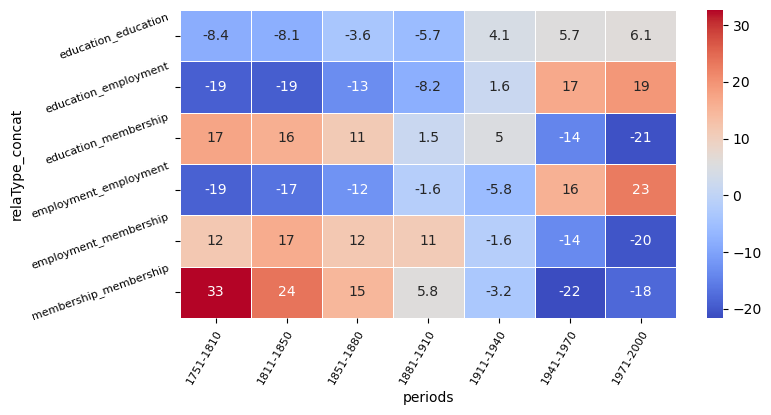

In [71]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Graph analysis


We will explore some aspects of the relationships:

* which organisations are connected through education, but this only at the level of universities, not earlier education stages
* in the same perspective (same kind of relations), we will explore memberships and employments, keeping them separated
* we will then ask what appears regarding the relationship between employment and membership
* we finally inspect if some kind of educational institutions (at unversity level) lead to specific employments or memberships.






### Organisations connected through higher education

In [74]:
pprint.pprint(sorted(df_mainTypes.mainType.to_list()))

['academy of sciences',
 'astronomical observatory',
 'company or gov. agency',
 'educational institution',
 'institute of technology',
 'learned society',
 'not classified organisation',
 'private university',
 'public university',
 'research facility',
 'research organisation',
 'scientific organisation',
 'university']


In [75]:
types_list=['university', 'public university', 'private university']

In [76]:
df_edu_graph = df_graph[(df_graph.relaType_concat == 'education_education') \
                     & (df_graph.orgMainType_x.isin(types_list)) \
                     & (df_graph.orgMainType_y.isin(types_list))  ]

print(len(df_edu_graph))
df_edu_graph.iloc[:2]

5833


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
8,1751-1810,education_education,http://www.wikidata.org/entity/Q106947038,Q106947038,university,http://www.wikidata.org/entity/Q3064332,Science Faculty of Paris,university,Mikhail Ostrogradsky,http://www.wikidata.org/entity/Q355892,1
21,1751-1810,education_education,http://www.wikidata.org/entity/Q1189954,Mines ParisTech,public university,http://www.wikidata.org/entity/Q209842,University of Paris,university,Angelo Sismonda,http://www.wikidata.org/entity/Q3617232,1


In [77]:
df_edu_graph.sort_values(by='number',ascending=False).iloc[:2]

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
40961,1911-1940,education_education,http://www.wikidata.org/entity/Q13164,Moscow State University,public university,http://www.wikidata.org/entity/Q2367144,MSU Faculty of Physics,university,Vitaly Ginzburg|Lev Altshuler|Q15073626|Anatol...,http://www.wikidata.org/entity/Q104668|http://...,27
40960,1911-1940,education_education,http://www.wikidata.org/entity/Q13164,Moscow State University,public university,http://www.wikidata.org/entity/Q2367115,MSU Faculty of Mechanics and Mathematics,university,Valentin Esipov|Gary Gavrilov|Vladimir Arnold|...,http://www.wikidata.org/entity/Q112133335|http...,23


In [78]:
### Number of relationships by period
print(df_edu_graph.groupby('periods').size())

periods
1751-1810      93
1811-1850     161
1851-1880     389
1881-1910     870
1911-1940    1757
1941-1970    1960
1971-2000     603
dtype: int64


### Inspect a specific period

In [80]:
p = '1881-1910' #'1851-1880' #'1911-1940'

In [81]:
df_edu_graph_p = df_edu_graph[(df_edu_graph.periods==p)]
df_edu_graph_p.sort_values(by='number',ascending=False).head(2)

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
21482,1881-1910,education_education,http://www.wikidata.org/entity/Q332342,Trinity College,university,http://www.wikidata.org/entity/Q35794,University of Cambridge,university,William Lawrence Bragg|William McCrea|Subrahma...,http://www.wikidata.org/entity/Q131729|http://...,12
20703,1881-1910,education_education,http://www.wikidata.org/entity/Q152838,University of Göttingen,public university,http://www.wikidata.org/entity/Q55044,Ludwig-Maximilian-University in Munich,public university,Dimitrios Chondros|Werner Uhink|Wilhelm Heinri...,http://www.wikidata.org/entity/Q12876062|http:...,10


In [82]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriOrg_x'], e['uriOrg_y'],
     {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
      ## the weight ist the number of persons in this relationship
      'weight':e['number']}
     )) 
     for e in df_edu_graph_p.to_dict(orient='records')]
print(len(l))

870


In [83]:
edu_graph_p=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
edu_graph_p.add_edges_from(l)

naf.basic_graph_properties(edu_graph_p)

### Create a list of graphs, one per component
edu_graph_p_S = [edu_graph_p.subgraph(c).copy() for c in nx.connected_components(edu_graph_p)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(edu_graph_p_S)], key = lambda row: row[1], reverse=True)
print(ln[:5])

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 412,
 'number_of_edges': 870,
 '------': '------',
 'is connected': False,
 'components': 14,
 'density': 0.010275671461980015}
[[0, 384], [3, 3], [5, 3], [1, 2], [2, 2]]


In [84]:
### test if second component is significantly smaller 
# than first
if ln[1][1]*20 < ln[0][1]:
    print('Just one big component')
else :
    print('Beware: more than one big component !')    

Just one big component


In [85]:
### Alternative way with just one graph
pG = edu_graph_p_S[0]
naf.basic_graph_properties(pG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 384,
 'number_of_edges': 854,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.011613359442993907}


In [86]:
df_orgPeriod.sort_values(by='period_members_number', ascending=False).head(2)

,uriOrg,labelOrg,orgMainType,periods,period_members_number
12046,http://www.wikidata.org/entity/Q6867,International Astronomical Union,scientific organisation,1941-1970,883
6083,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,1911-1940,518


In [87]:
df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']
df_opl.head()


,uri,label,mainType,membersNumber
0,http://www.wikidata.org/entity/Q100148173,Samaldas Arts College,educational institution,1
7,http://www.wikidata.org/entity/Q1003730,Bulgarian Academy of Sciences,academy of sciences,10
10,http://www.wikidata.org/entity/Q1004412,Bulletin of the Atomic Scientists,company or gov. agency,1
19,http://www.wikidata.org/entity/Q1007545,Galatasaray High School,educational institution,1
37,http://www.wikidata.org/entity/Q1010477,International Time Bureau,not classified organisation,1


In [88]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'mainType':e['mainType'],
                        'membersNumber':e['membersNumber']}
     ) for e in df_opl.to_dict(orient='records')])
## Add attributes
nx.set_node_attributes(pG, ln)
pprint.pprint(list(pG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q102398072',
  {'label': 'philosophy faculty of the German university of Prague',
   'mainType': 'university',
   'membersNumber': 6}),
 ('http://www.wikidata.org/entity/Q102398197',
  {'label': 'Faculty of Law, German University in Prague',
   'mainType': 'university',
   'membersNumber': 1})]


In [89]:
mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
print(mn_s.groupby(by=mn_s).size().sort_values(ascending=False))

university            244
public university     109
private university     31
dtype: int64


####  Create dataframe and inspect node properties

In [90]:
### Eigenvector
le = list(nx.eigenvector_centrality(pG, 
                        max_iter=200, weight='weight').items())
nx.set_node_attributes(pG, dict(le), 'eigenvector')
pprint.pprint(list(pG.nodes.data())[:1])

[('http://www.wikidata.org/entity/Q102398072',
  {'eigenvector': 0.015222917458227885,
   'label': 'philosophy faculty of the German university of Prague',
   'mainType': 'university',
   'membersNumber': 6})]


In [91]:
### Betweenness
lb = list(nx.betweenness_centrality(pG, weight='weight').items())
nx.set_node_attributes(pG, dict(lb), 'betweenness')
pprint.pprint(list(pG.nodes.data())[:1])


[('http://www.wikidata.org/entity/Q102398072',
  {'betweenness': 0.006216690377060662,
   'eigenvector': 0.015222917458227885,
   'label': 'philosophy faculty of the German university of Prague',
   'mainType': 'university',
   'membersNumber': 6})]


In [92]:
### Export node attributes to dataframe
nodes_data ={node: pG.nodes[node] for node in pG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True, names='id')
nodes_df.head(2)


,id,label,mainType,membersNumber,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q102398072,philosophy faculty of the German university of...,university,6,0.015223,0.006217
1,http://www.wikidata.org/entity/Q102398197,"Faculty of Law, German University in Prague",university,1,0.000524,0.0


In [93]:
df_mainTypes

,mainType,number
12,university,25139
8,public university,13909
0,academy of sciences,8210
5,learned society,5551
7,private university,5030
3,educational institution,4634
10,research organisation,4325
4,institute of technology,3173
11,scientific organisation,2815
6,not classified organisation,2204


In [ ]:
### exclude less relevant or dirty classifications
lt=[t for t in df_mainTypes.mainType.to_list()
                if ('educat' not in t)  & ('classif' not in t)]
pprint.pprint(lt)

['university',
 'public university',
 'academy of sciences',
 'learned society',
 'private university',
 'research organisation',
 'institute of technology',
 'scientific organisation',
 'company or gov. agency',
 'astronomical observatory',
 'research facility']


In [95]:
### source
# https://phrogz.net/css/distinct-colors.html
col_l = [c.strip() for c in '#ff0066, #0000ff, #00aaff,#beb6f2, #b6e6f2, #e6f2b6, #f2b6b6,#2d50b3, #ccff00, #8c005e, #8c8300'.split(',')]
print(col_l)

['#ff0066', '#0000ff', '#00aaff', '#beb6f2', '#b6e6f2', '#e6f2b6', '#f2b6b6', '#2d50b3', '#ccff00', '#8c005e', '#8c8300']


In [96]:
col_list= [e for e in zip(lt, col_l)]
print(col_list)

[('university', '#ff0066'), ('public university', '#0000ff'), ('academy of sciences', '#00aaff'), ('learned society', '#beb6f2'), ('private university', '#b6e6f2'), ('research organisation', '#e6f2b6'), ('institute of technology', '#f2b6b6'), ('scientific organisation', '#2d50b3'), ('company or gov. agency', '#ccff00'), ('astronomical observatory', '#8c005e'), ('research facility', '#8c8300')]


In [97]:
color_map=dict([(c[0], (c[1])) for c in col_list])
pprint.pprint(color_map)

{'academy of sciences': '#00aaff',
 'astronomical observatory': '#8c005e',
 'company or gov. agency': '#ccff00',
 'institute of technology': '#f2b6b6',
 'learned society': '#beb6f2',
 'private university': '#b6e6f2',
 'public university': '#0000ff',
 'research facility': '#8c8300',
 'research organisation': '#e6f2b6',
 'scientific organisation': '#2d50b3',
 'university': '#ff0066'}


In [129]:
### Manually modified list
color_map = {'academy of sciences': '#00aaff',
 'astronomical observatory': '#8c005e',
 'company or gov. agency': '#ccff00',
 'institute of technology': '#f2b6b6',
 'learned society': '#ff0066',
 'private university': '#ffcc00',
 'public university': '#8c8300',
 'research facility': '#d90000',
 'research organisation': '#beb6f2',
 'scientific organisation': '#2d50b3',
 'university': '#b6e6f2'}

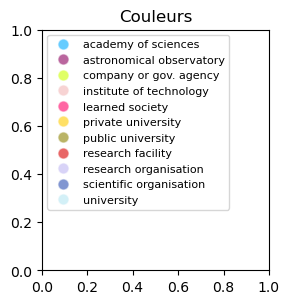

In [130]:

fig = plt.figure(figsize=(3,3))


### Create lists of colors and labels
colors = [color_map.keys()]
 

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=0.6
                            ) for label, color in color_map.items() ],
                            loc='upper left', fontsize=8)
plt.tight_layout() # rect=[0,0,0.8,1]

plt.title('Couleurs')

plt.show()

In [131]:
### Create a function that plots the comparison between values and properties

def compare_with_scatter_plot(dataframe, value_1, value_2, point_column,point_ratio=1, 
                              c_category='', color_map='', figsize=(12,12), 
                              legend_loc='upper right',title='', 
                              n_label ='', label_cut_value=''):

    ### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    # Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
    # Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    # Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point



    df=dataframe
    # df_extr=nodes_df[nodes_df.betweenness > 0].sort_values(by='betweenness', ascending=False)

    alpha=0.7

    ### Manage point colors:
    # https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

    plt.figure(figsize=figsize)


    ### Create lists of colors and labels
    colors = [color_map[category] for category in df[c_category]]
 



    ax = plt.scatter(df[value_1],
                df[value_2],
            marker='o',
            s = [v*point_ratio for i,v in df[point_column].items()],
            color=colors,        
            alpha=alpha)
    plt.xlabel(value_1.capitalize())
    plt.ylabel(value_2.capitalize())






    ### Labels
    test_v1 = df[value_1].quantile([0.97]).item()
    test_v2 = df[value_2].quantile([0.95]).item()
    print(test_v1,test_v2)


    if len(n_label)>0:
        for i,row in list(df.loc[(df[value_1]>test_v1)|(df[value_2]>test_v2)]\
                          [[n_label,value_1,value_2]].iterrows()):
            plt.annotate(row[n_label][:30],(row[value_1], row[value_2]), fontsize=6)

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=alpha
                            ) for label, color in color_map.items() 
                                    if label in types_list ],
                            loc=legend_loc, fontsize=8)
    plt.tight_layout() # rect=[0,0,0.8,1]

    plt.title(title)

    # plt.savefig('plots/revenus_eigenvector_20210526.jpg')
    plt.show()

0.09375758199857782 0.0312820771041274


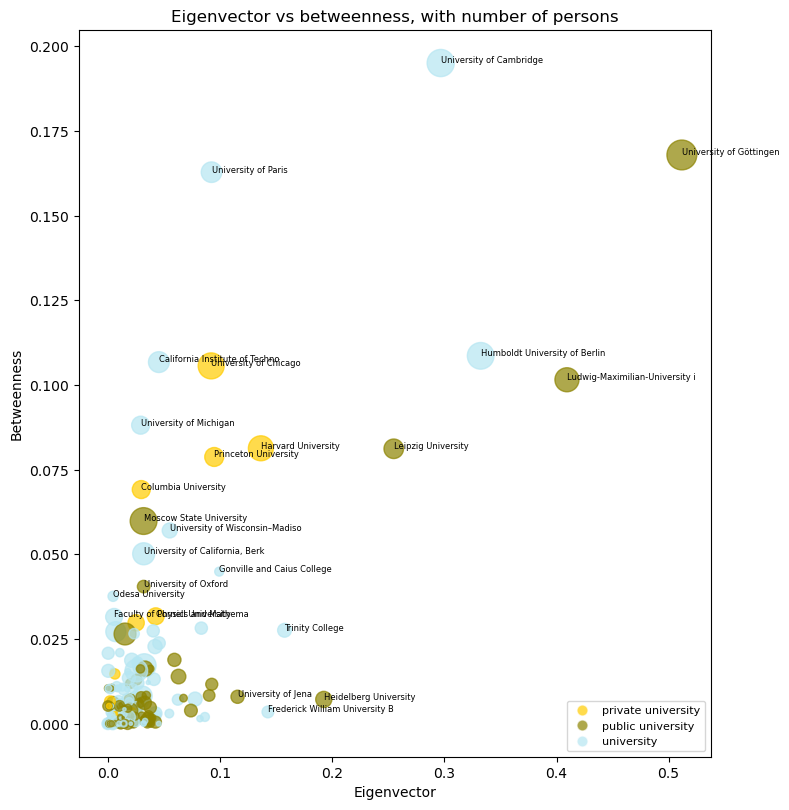

Spearman's rank correlation: 0.645765533624037


In [132]:
compare_with_scatter_plot(nodes_df, 'eigenvector', 'betweenness', 'membersNumber', 
                          point_ratio=3, c_category='mainType',
                          color_map=color_map, figsize=(8,8), 
                          legend_loc='lower right', 
                          title='Eigenvector vs betweenness, with number of persons', 
                          n_label='label', label_cut_value='membersNumber' )

corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
print("Spearman's rank correlation: {}".format(corr_spear.iloc[0,1]))

In [ ]:
list(nodes_df.columns)

In [102]:
print('Betweenness')
pprint.pprint((nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))
print('\n-----\nEigenvector')
pprint.pprint((nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))

Betweenness
                                      label            mainType membersNumber
23                  University of Cambridge          university           128
27                  University of Göttingen   public university           154
43                      University of Paris          university            73
78            Humboldt University of Berlin          university           123
109      California Institute of Technology          university            75
12                    University of Chicago  private university           117
4    Ludwig-Maximilian-University in Munich   public university           100

-----
Eigenvector
                                      label           mainType membersNumber
27                  University of Göttingen  public university           154
4    Ludwig-Maximilian-University in Munich  public university           100
78            Humboldt University of Berlin         university           123
23                  University of Cam

#### Plot graph

In [107]:
pict_addr = 'images/organisations/edu_edu_' + p +'.svg'
print(pict_addr)

images/organisations/edu_edu_1881-1910.svg


In [133]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]
node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                        label=label, markerfacecolor=color, 
                        markersize=12, alpha=alpha_n
                        )
                        for label, color in color_map.items()
                        if label in types_list ],
                        loc='lower right', fontsize=12)


### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr
plt.savefig(pict_addr)
#plt.show()
plt.close()


### Communitites

In [ ]:
l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
print( len(l_communities))
sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
print([c[1] for c in sl_communities])
print(sl_communities[-1:])


In [ ]:
for i in range(0,5):
   print('\n\nCommunity '+ str(i), '\nBetweenness')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))
   print('\n-----\nEigenvector')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))


#### Plot communitites graph

In [ ]:
pict_addr_comm = 'images/organisations/edu_edu_communities_' + p +'.svg'
print(pict_addr_comm)

In [ ]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]

node_colors = []
for n in g.nodes.data():
    if n[0] in list(sl_communities[0][0]):
        node_colors.append('red')
    elif n[0] in list(sl_communities[1][0]):
        node_colors.append('blue')
    elif n[0] in list(sl_communities[2][0]):
        node_colors.append('green')
    elif n[0] in list(sl_communities[3][0]):
        node_colors.append('orange')
    elif n[0] in list(sl_communities[4][0]):
        node_colors.append('maroon')
    else:
        node_colors.append('lightGrey')        


edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5



### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr_comm
plt.savefig(pict_addr)
#plt.show()
plt.close()


## Create general function

In [ ]:
def generate_report_and_plots(df, concatRelaType, type_list, doc_addr, df_orgPeriod):

    with open(doc_addr, "w") as myfile:
        myfile.write('# Report for relations: ' + concatRelaType + '\n')


    df_g = df[(df.relaType_concat == concatRelaType) \
                     & (df.orgMainType_x.isin(type_list)) \
                     & (df.orgMainType_y.isin(type_list))  ]

    txt = str(df_g.groupby('periods').size())

    with open(doc_addr, "a") as myfile:
        myfile.write('\n'+txt + '\n')

    for p in df_g['periods'].unique():
        print(str(p))   

        with open(doc_addr, "a") as myfile:
            myfile.write('\n\n\n## Values for ' + p + '\n')

        df_g_p = df_g[df_g.periods==p]
        
        with open(doc_addr, "a") as myfile:
            myfile.write('\nNumber of relationships for this period ' + str(len(df_g_p)) + '\n')
        
        l = [tuple(
            (e['uriOrg_x'], e['uriOrg_y'],
            {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
            ## the weight ist the number of persons in this relationship
            'weight':e['number']}
            )) 
            for e in df_g_p.to_dict(orient='records')]
        
        graph_p=nx.Graph()
        graph_p.add_edges_from(l)

        txt = 'Number of nodes: ' + str(graph_p.number_of_nodes())+\
                '\nNumber of edges: ' + str(graph_p.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### Components
        graph_p_S = [graph_p.subgraph(c).copy() 
                     for c in nx.connected_components(graph_p)]

        ln = sorted([[i,len(s.nodes)] for i,s in enumerate(graph_p_S)], key = lambda row: row[1], reverse=True)
        try:
            if ln[1][1]*20 < ln[0][1]:
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nJust one big component with ' + str(graph_p_S[0].number_of_nodes()) + ' nodes\n')            
            else :
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nBeware: more than one big component !'  + '\n')
        except Exception as e:
             print(e)            
            
        ### Alternative way with just one graph
        pG = graph_p_S[0]

        txt = 'Number of nodes for first component: ' + str(pG.number_of_nodes())+\
                '\nNumber of edges for first component: ' + str(pG.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### No treatment for smaller graphs
        if int(pG.number_of_nodes()) > 30:

            ### Prepare data to add to nodes

            df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
            df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']

            ln = dict([(e['uri'],
                {'label':e['label'], 'mainType':e['mainType'],
                                    'membersNumber':e['membersNumber']}
                ) for e in df_opl.to_dict(orient='records')])
            ## Add attributes
            nx.set_node_attributes(pG, ln)

            mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
            txt= str(list(mn_s.groupby(by=mn_s).size().sort_values(ascending=False).items()))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            ### Eigenvector
            try:
                le = list(nx.eigenvector_centrality(pG, 
                                        max_iter=1000, weight='weight').items())
            except Exception as e:
                print(e)    
            nx.set_node_attributes(pG, dict(le), 'eigenvector')   

            ### Betweenness
            lb = list(nx.betweenness_centrality(pG, weight='weight').items())
            nx.set_node_attributes(pG, dict(lb), 'betweenness')


            ### Export node attributes to dataframe
            nodes_data ={node: pG.nodes[node] for node in pG.nodes}
            nodes_df = pd.DataFrame(nodes_data).T
            nodes_df.reset_index(inplace=True, names='id')

            corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
            txt = "Spearman's rank correlation of eidenvector and betweenness: {}".format(corr_spear.iloc[0,1])
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            txt = 'Eigenvector\n' + \
                str(nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7) )+\
                '\n-----\nBetweenness'+\
                str(nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')


            pict_addr = 'images/organisations/' + concatRelaType + '_' + p +'.svg'        


            ### Plot the graph
            g = pG
            # n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
            n_size = np.log(nx.number_of_nodes(g))*10

            graph_layout = 'spring_layout'
            n_k = np.log(nx.number_of_nodes(g))/20 #2.5

            ### Define the layout, i.e. the choice 
            # of the algorithm for the representation of the graph.

            if graph_layout == 'fruchterman_reingold':
                pos = nx.fruchterman_reingold_layout(g)
            elif graph_layout == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(g)
            elif graph_layout == 'spring_layout':
                pos = nx.spring_layout(g, k = n_k)  
            else:
                pos = nx.kamada_kawai_layout(g)

            # https://networkx.org/documentation/stable/reference/drawing.html
            plt.figure(figsize = (n_size,n_size))

            node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
            #node_size = [d[1]*100 for d in nx.degree(g)]
            #node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

            edge_size = [e[2]['weight'] for e in g.edges.data()]
            edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

            node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


            nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color='blue', alpha=0.6)
            nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
            nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
            #nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

            alpha_n=0.5

            plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                                    label=label, markerfacecolor=color, 
                                    markersize=8, alpha=alpha_n
                                    )
                                    for label, color in color_map.items()],
                                    loc='lower right', fontsize=8)


            ### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
            plt.tight_layout(pad=60)
            pict_addr = pict_addr
            plt.savefig(pict_addr)
            #plt.show()
            plt.close()


            ### Identify communitites
            l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
            sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
            txt= 'Number of communitites: ' + str(len(l_communities)) +\
                    '\nNumber of nodes per community: ' + str([c[1] for c in sl_communities])
            with open(doc_addr, "a") as myfile:
                myfile.write('\n'+ txt  + '\n')

            communities_print = 'Communities: \n'
            try:
                for i in range(0,5):
                    communities_print += '\n\nCommunity '+ str(i) + '\nBetweenness'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ]\
                                                .sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                    communities_print += '\n-----\nEigenvector'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ communities_print  + '\n')
            except Exception as e:
                 print(e)        

        else:
            print('Too small graph to be analyzed!')        


In [ ]:
print(df_mainTypes.mainType.to_list())

In [ ]:
relationship_type = 'education_education'
generate_report_and_plots(df_graph, relationship_type,
                           ['university','public university','private university'],
                           'analysis_doc/'+relationship_type+'.md',
                           df_orgPeriod)

In [ ]:
relationship_type = 'membership_membership'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

In [ ]:
relationship_type = 'employment_employment'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)